In [39]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [40]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data.head(3)

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,146.463730,171.808746,171.628006,160.639999,113.183418,87.368553,370.019684,492.459991,192.012970,57.146446,...,170.748978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,145.083298,172.903580,172.216553,161.860001,110.194344,86.912125,368.113281,513.859985,188.097961,58.206318,...,168.888824,0.661258,60.689945,67548.593750,3517.985107,18.324354,87.112206,195.992752,0.000217,0.647565
2024-03-19,146.374374,175.252502,173.345444,161.789993,110.899956,87.168869,373.457123,521.190002,187.429062,58.803699,...,171.134842,0.586914,53.525894,61912.773438,3157.618164,16.809296,78.586372,170.016281,0.000198,0.584441


For stationarity checks, I referred briefly to this paper: https://business.columbia.edu/sites/default/files-efs/pubfiles/3970/computing_efficient_frontiers.pdf section 8 

## Stationarity check on daily prices

In [41]:
def check_stationarity_price(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on all asset price series in the dataset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}

    for asset in data.columns:
        series = data[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [42]:
results_price = check_stationarity_price(data)
(results_price["Stationary"] == 0).sum()

488

In [43]:
def plot_daily_price(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily price for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    series_asset = data[asset_name].dropna()
    result_asset = adfuller(series_asset)

    # Plot the daily returns for the specified asset
    plt.figure(figsize=(10, 6))
    plt.plot(data[asset_name].dropna(), label=f'Daily Returns - {asset_name}')
    plt.title(f'Daily Price of {asset_name}')
    plt.xlabel('Date')
    plt.ylabel('Daily Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(result_asset[1])


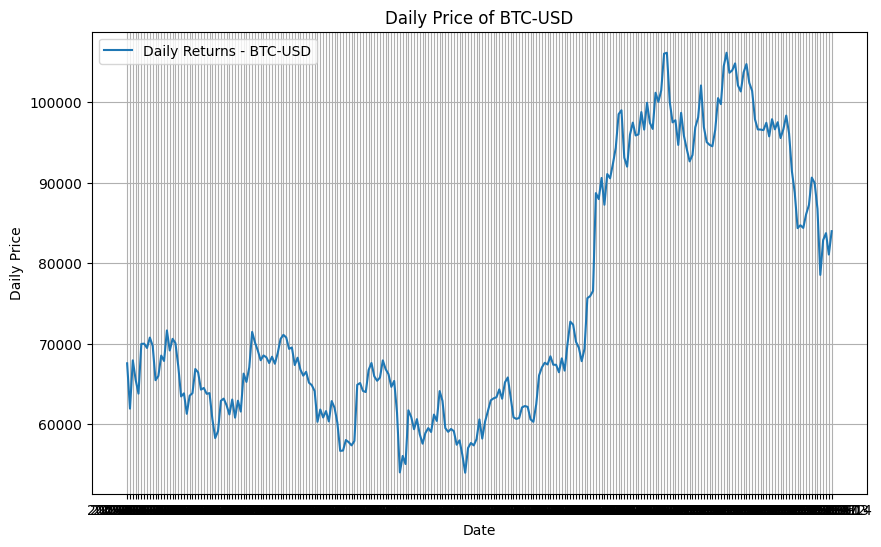

0.6624071195859544


In [44]:
plot_daily_price(data, 'BTC-USD')

## Stationarity check on daily returns 

In [45]:
def check_stationarity_all(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on daily returns of each asset 

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}
    daily_returns = data.pct_change()

    for asset in data.columns:
        series = daily_returns[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [46]:
# Run stationarity check for all assets
results = check_stationarity_all(data)
results

,Asset,Stationary
0,A,1
1,AAPL,1
2,ABBV,1
3,ABNB,1
4,ABT,1
...,...,...
502,LINK-USD,1
503,LTC-USD,1
504,SOL-USD,1
505,UNI-USD,1


In [47]:
(results["Stationary"] == 0).sum()

0

In [48]:
def plot_daily_returns(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily returns for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    # Calculate daily returns
    daily_returns = data.pct_change()

    series_asset = daily_returns[asset_name].dropna()
    result_asset = adfuller(series_asset)

    # Plot the daily returns for the specified asset
    plt.figure(figsize=(10, 6))
    plt.plot(daily_returns[asset_name].dropna(), label=f'Daily Returns - {asset_name}')
    plt.title(f'Daily Returns of {asset_name}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(result_asset[1])


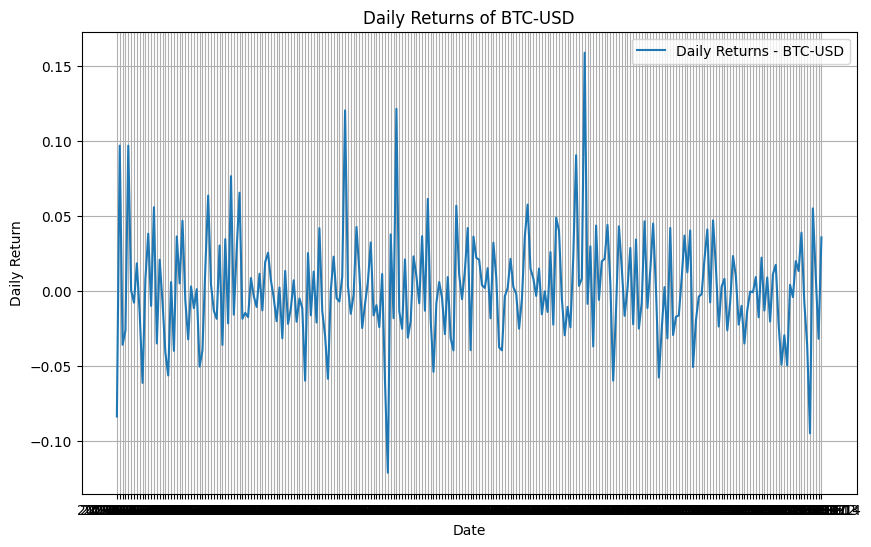

7.309960900848485e-30


In [49]:
plot_daily_returns(data, 'BTC-USD')